# Introduction
Time series analysis refers to the analysis of change in the trend of the data over a period of time. Time series analysis has a variety of applications. One such application is the prediction of the future value of an item based on its past values. Future stock price prediction is probably the best example of such an application.

## Import Basic Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Import Dataset
The data that we are going to be downloaded from Yahoo Finance. For training our algorithm, we will be using the Apple stock prices from 1st January 2018 to 30 april 2020. For the sake of prediction, we will use the Apple stock prices for the month of may and june 2020. So in order to evaluate the performance of the algorithm, download the actual stock prices for the month of may and june 2020 as well.

Let's now see how our data looks. You will see that it contain seven columns Date, Open, High, Low, Close, Adj Close and Volume. We will be predicting the opening stock price, therefore we are not interested in the rest of the columns.

In [2]:
apple_training_complete = pd.read_csv(r'C:\Users\DELL\Desktop\apple_training.csv')
apple_training_complete

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/2018,170.160004,172.300003,169.259995,172.259995,166.353714,25555900
1,03/01/2018,172.529999,174.550003,171.960007,172.229996,166.324722,29517900
2,04/01/2018,172.539993,173.470001,172.080002,173.029999,167.097290,22434600
3,05/01/2018,173.440002,175.369995,173.050003,175.000000,168.999741,23660000
4,08/01/2018,174.350006,175.610001,173.929993,174.350006,168.372040,20567800
...,...,...,...,...,...,...,...
581,24/04/2020,277.200012,283.010010,277.000000,282.970001,282.206085,31627200
582,27/04/2020,281.799988,284.540009,279.950012,283.170013,282.405548,29271900
583,28/04/2020,285.079987,285.829987,278.200012,278.579987,277.827911,28001200
584,29/04/2020,284.730011,289.670013,283.890015,287.730011,286.953247,34320200


As we said earlier, we are only interested in the opening price of the stock. Therefore, we will filter all the data from our training set and will retain only the values for the Open column.

In [3]:
apple_training_processed = apple_training_complete.iloc[:, 1:2].values


# Data Normalization
As a rule of thumb, whenever you use a neural network, you should normalize or scale your data. We will use MinMaxScaler class from the sklear.preprocessing library to scale our data between 0 and 1. The feature_range parameter is used to specify the range of the scaled data. Execute the following script:

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

apple_training_scaled = scaler.fit_transform(apple_training_processed)

# Convert Training Data to Right Shape
As I said earlier, in a time series problems, we have to predict a value at time T, based on the data from T-N days where N can be any number of steps. In this we are going to predict the opening stock price of the data based on the opening stock prices for the past 60 days. 

Our feature set should contain the opening stock price values for the past 60 days while the label or dependent variable should be the stock price at the 61st day. Execute the following script to create feature and label set.

In [5]:
features_set = []
labels = []
for i in range(60, 586):
    features_set.append(apple_training_scaled[i-60:i, 0])
    labels.append(apple_training_scaled[i, 0])

In the script above we create two lists: feature_set and labels. There are 586 records in the training data. We execute a loop that starts from 61st record and stores all the previous 60 records to the feature_set list. The 61st record is stored in the labels list.

We need to convert both the feature_set and the labels list to the numpy array before we can use it for training. Execute the following script

In [6]:
features_set, labels = np.array(features_set), np.array(labels)

In order to train LSTM on our data, we need to convert our data into the shape accepted by the LSTM. We need to convert our data into three-dimensional format. The first dimension is the number of records or rows in the dataset which is 586 in our case. The second dimension is the number of time steps which is 60 while the last dimension is the number of columns. Since we are only using one feature, i.e Open, the number of indicators will be one. Execute the following script:

In [7]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))
features_set.shape 

(526, 60, 1)

# Training The LSTM
We have preprocessed our data and have converted it into the desired format. now is the time to create our LSTM. The LSTM model that we are going to create will be a sequential model with multiple layers. We will add four LSTM layers to our model followed by a dense layer that predicts the future stock price.

Let's first import the libraries that we are going to need in order to create our model:

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In the script above we imported the Sequential class from keras.models library and Dense, LSTM, and Dropout classes from keras.layers library.

As a first step, we need to instantiate the Sequential class. This will be our model class and we will add LSTM, Dropout and Dense layers to this model. Execute the following script

In [10]:
model = Sequential()

Creating LSTM and Dropout Layers
Let's add LSTM layer to the model that we just created. Execute the following script to do so:

In [11]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))

To add a layer to the sequential model, the add method is used. Inside the add method, we passed our LSTM layer. The first parameter to the LSTM layer is the number of neurons or nodes that we want in the layer. The second parameter is return_sequences, which is set to true since we will add more layers to the model. The first parameter to the input_shape is the number of time steps while the last parameter is the number of indicators.

Let's now add a dropout layer to our model. Dropout layer is added to avoid over-fitting, which is a phenomenon where a machine learning model performs better on the training data compared to the test data. Execute the following script to add dropout layer.

In [13]:
model.add(Dropout(0.2))

Let's add three more LSTM and dropout layers to our model. Run the following script.

In [14]:
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

## Creating Dense Layer
To make our model more robust, we add a dense layer at the end of the model. The number of neurons in the dense layer will be set to 1 since we want to predict a single value in the output.

In [15]:
model.add(Dense(units = 1))

## Model Compilation
Finally, we need to compile our LSTM before we can train it on the training data. The following script compiles the our model.

We call the compile method on the Sequential model object which is "model" in our case. We use the mean squared error as loss function and to reduce the loss or to optimize the algorithm, we use the adam optimizer.

In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Algorithm Training
Now is the time to train the model that we defined in the previous few steps. To do so, we call the fit method on the model and pass it our training features and labels as shown below:

In [17]:
model.fit(features_set, labels, epochs = 50, batch_size = 20)

Epoch 1/50
526/526 [==============================] - 11s 21ms/step - loss: 0.0551
Epoch 2/50
526/526 [==============================] - 8s 15ms/step - loss: 0.0117
Epoch 3/50
526/526 [==============================] - 8s 15ms/step - loss: 0.0091
Epoch 4/50
526/526 [==============================] - 8s 15ms/step - loss: 0.0087
Epoch 5/50
526/526 [==============================] - 8s 15ms/step - loss: 0.0084
Epoch 6/50
526/526 [==============================] - 8s 15ms/step - loss: 0.0071
Epoch 7/50
526/526 [==============================] - 8s 15ms/step - loss: 0.0057
Epoch 8/50
526/526 [==============================] - 12s 22ms/step - loss: 0.0063
Epoch 9/50
526/526 [==============================] - 10s 19ms/step - loss: 0.0064
Epoch 10/50
526/526 [==============================] - 8s 14ms/step - loss: 0.0050
Epoch 11/50
526/526 [==============================] - 8s 15ms/step - loss: 0.0049
Epoch 12/50
526/526 [==============================] - 8s 14ms/step - loss: 0.0055
Epoch 13/5

# Testing our LSTM
We have successfully trained our LSTM, now is the time to test the performance of our algorithm on the test set by predicting the opening stock prices for the month of may and june 2020. However, as we did with the training data, we need to convert our test data in the right format.

Let's first import our test data. Execute the following script:

In [18]:
apple_testing_complete = pd.read_csv(r'C:\Users\DELL\Desktop\apple_testing.csv')
apple_testing_processed = apple_testing_complete.iloc[:, 1:2]
apple_testing_processed

,Open
0,286.250000
1,289.170013
2,295.059998
3,300.459991
4,303.220001
5,305.640015
6,308.100006
7,317.829987
8,312.149994
9,304.510010


In the above script, we import our test data and as we did with the training data, we removed all the columns from the test data except the column that contains opening stock prices.

## Converting Test Data to Right Format
For each day of may and june 2020, we want our feature set to contain the opening stock prices for the previous 60 days. For the 1st of may, we need the stock prices for the previous 60 days. To do so, we need to concatenate our training data and test data before preprocessing. Execute the following script to do so:

In [19]:
apple_total = pd.concat((apple_training_complete['Open'], apple_testing_complete['Open']), axis=0)

Now let's prepare our test inputs. The input for each day should contain the opening stock prices for the previous 60 days. That means we need opening stock prices for the 29 test days for the month of may and june 2020 and the 60 stock prices from the last 60 days for the training set. Execute the following script to fetch those 80 values.

In [21]:
test_inputs = apple_total[len(apple_total) - len(apple_testing_complete) - 60:].values
test_inputs.shape

(89,)

As we did for the training set, we need to scale our test data. Execute the following script:

In [22]:
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

We scaled our data, now let's prepare our final test input set that will contain previous 60 stock prices for the month of may. Execute the following script:

In [23]:
test_features = []
for i in range(60, 89):
    test_features.append(test_inputs[i-60:i, 0]) 

Finally, we need to convert our data into the three-dimensional format which can be used as input to the LSTM. Execute the following script:

In [24]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
test_features.shape

(29, 60, 1)

Making Predictions


In [25]:
predictions = model.predict(test_features)


Since we scaled our data, the predictions made by the LSTM are also scaled. We need to reverse the scaled prediction back to their actual values. To do so, we can use the ìnverse_transform method of the scaler object we created during training. Take a look at the following script:

In [26]:
predictions = scaler.inverse_transform(predictions)
predictions

array([[289.54462],
       [289.70172],
       [290.17725],
       [291.06012],
       [292.4915 ],
       [294.52625],
       [297.10724],
       [300.10938],
       [303.59747],
       [307.2769 ],
       [310.59012],
       [313.03656],
       [314.78085],
       [316.07394],
       [317.14322],
       [318.14957],
       [319.053  ],
       [320.0035 ],
       [320.83615],
       [321.4279 ],
       [321.77805],
       [321.86633],
       [321.78394],
       [321.70956],
       [321.72885],
       [321.81674],
       [322.11444],
       [322.71365],
       [324.02795]], dtype=float32)

Finally, let's see how well did our algorithm predicted the future stock prices. Execute the following script:

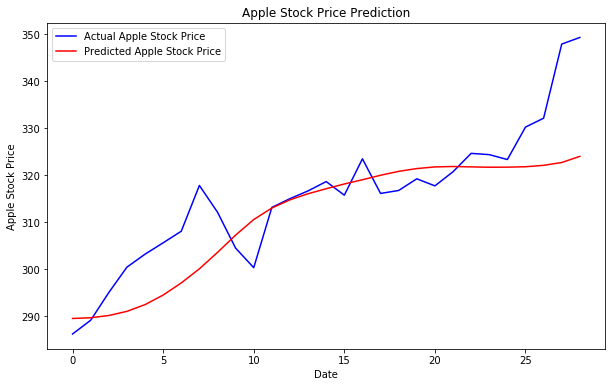

In [27]:
plt.figure(figsize=(10,6))
plt.plot(apple_testing_processed, color='blue', label='Actual Apple Stock Price')
plt.plot(predictions , color='red', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In the output, the blue line represents the actual stock prices for the month of may and june 2020, while the red line represents the predicted stock prices. You can clearly see that our algorithm has been able to capture the overall trend.

# Conclusion
A long short-term memory network (LSTM) is one of the most commonly used neural networks for time series analysis. The ability of LSTM to remember previous information makes it ideal for such tasks. we saw how we can use LSTM for the Apple stock price prediction. I would suggest that you download stocks of some other organization like Google or Microsoft from Yahoo Finance and see if your algorithm is able to capture the trends.

# Time Series Forecasting of stock prices

# Import all Libraries

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Import Dataset of Apple stock price


 we will be using the Apple stock prices from 1st January 2018 to 11 june 2020 and try to forcast future values

In [35]:
#Importing dataset
df= pd.read_csv(r'C:\Users\DELL\Desktop\AAPL.csv')
df= df.iloc[:, 0:2]
df

,Date,Open
0,02/01/2018,170.160004
1,03/01/2018,172.529999
2,04/01/2018,172.539993
3,05/01/2018,173.440002
4,08/01/2018,174.350006
...,...,...
610,05/06/2020,323.350006
611,08/06/2020,330.250000
612,09/06/2020,332.140015
613,10/06/2020,347.899994


Now try to indexing the date colum that is now our index is Date column

In [36]:
df.Date=pd.to_datetime(df.Date,format="%d/%m/%Y")
df=df.set_index('Date')
df.tail()

,Open
Date,
2020-06-05,323.350006
2020-06-08,330.250000
2020-06-09,332.140015
2020-06-10,347.899994
2020-06-11,349.309998


# Data Normalization
As a rule of thumb, whenever you use a neural network, you should normalize or scale your data. We will use MinMaxScaler class from the sklear.preprocessing library to scale our data between 0 and 1. The feature_range parameter is used to specify the range of the scaled data. Execute the following script:

In [37]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

df_scaled = scaler.fit_transform(df)

# Convert Training Data to Right Shape
As I said earlier, in a time series problems, we have to predict a value at time T, based on the data from T-N days where N can be any number of steps. In this we are going to predict the opening stock price of the data based on the opening stock prices for the past 60 days.

Our feature set should contain the opening stock price values for the past 60 days while the label or dependent variable should be the stock price at the 61st day. Execute the following script to create feature and label set.

In [38]:
forecast_features_set = []
labels = []
for i in range(60, 615):
    forecast_features_set.append(df_scaled[i-60:i, 0])
    labels.append(df_scaled[i, 0])

In [39]:
forecast_features_set , labels = np.array(forecast_features_set ), np.array(labels)

In [40]:
forecast_features_set = np.reshape(forecast_features_set, (forecast_features_set.shape[0], forecast_features_set.shape[1], 1))
forecast_features_set.shape 

(555, 60, 1)

# Training The LSTM
We have preprocessed our data and have converted it into the desired format. now is the time to create our LSTM. The LSTM model that we are going to create will be a sequential model with multiple layers. We will add four LSTM layers to our model followed by a dense layer that predicts the future stock price

In [41]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(forecast_features_set.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.fit(forecast_features_set, labels, epochs = 50, batch_size = 20)

Epoch 1/50
555/555 [==============================] - 10s 18ms/step - loss: 0.0406
Epoch 2/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0111
Epoch 3/50
555/555 [==============================] - 8s 15ms/step - loss: 0.0093
Epoch 4/50
555/555 [==============================] - 8s 14ms/step - loss: 0.0074
Epoch 5/50
555/555 [==============================] - 8s 14ms/step - loss: 0.0067
Epoch 6/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0064
Epoch 7/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0050
Epoch 8/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0044
Epoch 9/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0054
Epoch 10/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0045
Epoch 11/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0042
Epoch 12/50
555/555 [==============================] - 7s 13ms/step - loss: 0.0038
Epoch 13/50


Now we make a funsction forecast list to store all values that is output values

In [51]:
forecast_list=[]

batch=df_scaled[-forecast_features_set.shape[1]:].reshape((1,forecast_features_set.shape[1],1))

for i in range(forecast_features_set.shape[1]):
    forecast_list.append(model.predict(batch)[0])
    batch = np.append(batch[:,1:,:], [[forecast_list[i]]], axis=1)

In [52]:
df_predict=pd.DataFrame(scaler.inverse_transform(forecast_list),index=df[-forecast_features_set.shape[1]:].index, 
                        columns=["prediction"])

df_predict =pd.concat([df,df_predict],axis=1)
df_predict.tail()

,Open,prediction
Date,,
2020-06-05,323.350006,302.095953
2020-06-08,330.250000,303.636893
2020-06-09,332.140015,305.165338
2020-06-10,347.899994,306.651388
2020-06-11,349.309998,308.135676


now we are going to add some furure dates for which we are trying to obtain forecasted stock price

In [53]:
from pandas.tseries.offsets import DateOffset
add_dates=[df.index[-1]+DateOffset(days=x) for x in range(0,61)]
future_dates=pd.DataFrame(index=add_dates[1:],columns=df.columns)

In [54]:
future_dates.tail(60)

,Open
2020-06-12,NaN
2020-06-13,NaN
2020-06-14,NaN
2020-06-15,NaN
2020-06-16,NaN
2020-06-17,NaN
2020-06-18,NaN
2020-06-19,NaN
2020-06-20,NaN
2020-06-21,NaN


we make a dataframe of forcasted values and store the forcasted stock price values in predction column

In [55]:
df_forecast=pd.DataFrame(scaler.inverse_transform(forecast_list),index=future_dates[-forecast_features_set.shape[1]:].index, 
                        columns=["prediction"])

df_forecast =pd.concat([df,df_forecast],axis=1)

In [56]:
df_forecast.tail(60)

,Open,prediction
2020-06-12,NaN,323.956322
2020-06-13,NaN,326.171060
2020-06-14,NaN,327.960138
2020-06-15,NaN,329.067562
2020-06-16,NaN,329.442333
2020-06-17,NaN,329.243725
2020-06-18,NaN,328.626189
2020-06-19,NaN,327.672727
2020-06-20,NaN,326.498565
2020-06-21,NaN,325.138646


now we make a plot of past values and forecasted values. execute the script below

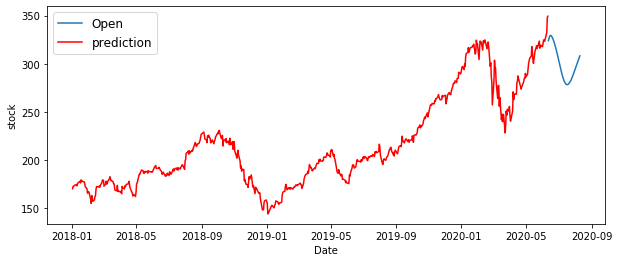

In [59]:
plt.figure(figsize=(10,4))
plt.plot(df_forecast.index,df_forecast["prediction"],label="Open")
plt.plot(df_predict.index,df_predict["Open"],color="r",label="prediction")
plt.legend(loc='best',fontsize='large')
plt.xlabel("Date")
plt.ylabel("stock")
plt.show()

# Conclusion
A long short-term memory network (LSTM) is one of the most commonly used neural networks for time series analysis. The ability of LSTM to remember previous information makes it ideal for such tasks. we saw how we can use LSTM for the Apple stock price prediction. I would suggest that you download stocks of some other organization like Google or Microsoft from Yahoo Finance and see if your algorithm is able to capture the trends.